In [44]:
# Import libraries
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt


# Passenger volume prediction model

## Importing and checking dataset

In [2]:
# Import dataset
df_flights = pd.read_csv("C:/Users/oabanderas/Downloads/Filghts_TEC_Valid.csv")

In [3]:
# Check dataset
df_flights

,Flight_ID,Aeronave,DepartureStation,ArrivalStation,Destination_Type,Origin_Type,STD,STA,Capacity,Passengers,Bookings
0,ab954014077430bd842cfa305a55c0f8,XA-VBY,AT,AZ,Ciudad Fronteriza,Ciudad Principal,2023-10-19 11:40:00,2023-10-19 14:25:00,240,229.0,157.0
1,efd86c996035dacdca7a0ccb2560dda1,XA-VIX,BM,AV,MX Amigos y Familia,Ciudad Fronteriza,2023-07-03 00:55:00,2023-07-03 04:55:00,186,197.0,109.0
2,6cfa1bbaa44f08fc7d3061f034a6a5ce,XA-VBV,AW,AS,MX Amigos y Familia,Ciudad Principal,2024-02-16 17:10:00,2024-02-16 17:55:00,220,NaN,NaN
3,dd0fad3248951d2f71d63e6279aeaa4b,XA-VBW,AW,AS,MX Amigos y Familia,Ciudad Principal,2023-06-26 15:15:00,2023-06-26 15:55:00,220,200.0,142.0
4,d0987ee648eea254063bfe2b39571b67,XA-VAP,BA,AB,Playa,Ciudad Principal,2023-02-10 08:40:00,2023-02-10 09:50:00,186,162.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...
245748,cc7c1c5e6fd132fd0bdab3a35aac33c0,XA-VBK,BM,BT,Playa,Ciudad Fronteriza,2023-12-29 07:30:00,2023-12-29 14:50:00,240,189.0,86.0
245749,ef32da2731db80faa8b9f5030979a016,9H-MLV,AW,BT,Playa,Ciudad Principal,2024-04-20 10:45:00,2024-04-20 14:00:00,178,NaN,NaN
245750,9c8970e9836d9c5ef9415bfa93c3f408,XA-VAC,AT,BT,Playa,Ciudad Principal,2023-12-22 12:50:00,2023-12-22 16:10:00,180,163.0,95.0
245751,3c15779202b13158f78e8a8afe377250,NaN,AW,BT,Playa,Ciudad Principal,2024-10-04 10:00:00,2024-10-04 13:15:00,240,NaN,NaN


We can check there are 245,753 rows, but we need to check if all rows are unique flights

In [4]:
#Check unique flights
len(df_flights["Flight_ID"].unique())

238055

There are 238,055 unique flights id, this is because some flights have more than one destination

In [5]:
# Check Null Values in dataset
nulls_flights = df_flights.isnull().sum()


# Review basic statistics for outliers or unusual values
stats_flights = df_flights.describe(include='all')


nulls_flights, stats_flights

(Flight_ID                0
 Aeronave             80390
 DepartureStation         1
 ArrivalStation           1
 Destination_Type         1
 Origin_Type              1
 STD                      0
 STA                      0
 Capacity                 0
 Passengers          123525
 Bookings            123525
 dtype: int64,
                                Flight_ID Aeronave DepartureStation  \
 count                             245753   165363           245752   
 unique                            238055      104               41   
 top     d2093576a84c20bb81f426f1596a0e5c   XA-VBU               AW   
 freq                                   4     2753            43082   
 mean                                 NaN      NaN              NaN   
 std                                  NaN      NaN              NaN   
 min                                  NaN      NaN              NaN   
 25%                                  NaN      NaN              NaN   
 50%                                  

There are a lot of NaN in Aeronave, we are not going to do anything about it because this column isn't important to predict passengers, since passengers don´t choose flights depending of the aircraft.

Passengers and booking has many null values ​​because since January 1, 2024 it does not contain that information.

In [6]:
# Separate the STD AND STA column into year, month, day and time. Rounding the hour column

# Convert STD and STA columns to datetime
df_flights['STD'] = pd.to_datetime(df_flights['STD'])
df_flights['STA'] = pd.to_datetime(df_flights['STA'])

# Extract year, month, day and time from STD
df_flights['STD_Year'] = df_flights['STD'].dt.year
df_flights['STD_Month'] = df_flights['STD'].dt.month
df_flights['STD_Day'] = df_flights['STD'].dt.day
df_flights['STD_Hour'] = df_flights['STD'].dt.hour + round(df_flights['STD'].dt.minute / 60)

# Extract year, month, day and time from STA
df_flights['STA_Year'] = df_flights['STA'].dt.year
df_flights['STA_Month'] = df_flights['STA'].dt.month
df_flights['STA_Day'] = df_flights['STA'].dt.day
df_flights['STA_Hour'] = df_flights['STA'].dt.hour + round(df_flights['STA'].dt.minute / 60)

In [7]:
df_flights.head()

,Flight_ID,Aeronave,DepartureStation,ArrivalStation,Destination_Type,Origin_Type,STD,STA,Capacity,Passengers,Bookings,STD_Year,STD_Month,STD_Day,STD_Hour,STA_Year,STA_Month,STA_Day,STA_Hour
0,ab954014077430bd842cfa305a55c0f8,XA-VBY,AT,AZ,Ciudad Fronteriza,Ciudad Principal,2023-10-19 11:40:00,2023-10-19 14:25:00,240,229.0,157.0,2023,10,19,12.0,2023,10,19,14.0
1,efd86c996035dacdca7a0ccb2560dda1,XA-VIX,BM,AV,MX Amigos y Familia,Ciudad Fronteriza,2023-07-03 00:55:00,2023-07-03 04:55:00,186,197.0,109.0,2023,7,3,1.0,2023,7,3,5.0
2,6cfa1bbaa44f08fc7d3061f034a6a5ce,XA-VBV,AW,AS,MX Amigos y Familia,Ciudad Principal,2024-02-16 17:10:00,2024-02-16 17:55:00,220,NaN,NaN,2024,2,16,17.0,2024,2,16,18.0
3,dd0fad3248951d2f71d63e6279aeaa4b,XA-VBW,AW,AS,MX Amigos y Familia,Ciudad Principal,2023-06-26 15:15:00,2023-06-26 15:55:00,220,200.0,142.0,2023,6,26,15.0,2023,6,26,16.0
4,d0987ee648eea254063bfe2b39571b67,XA-VAP,BA,AB,Playa,Ciudad Principal,2023-02-10 08:40:00,2023-02-10 09:50:00,186,162.0,90.0,2023,2,10,9.0,2023,2,10,10.0


A high season column will be added, where 1 is high season and 0 is low season. This is because flights are affected by whether it is high or low season. It is determined if it is high season with the Mexican school calendar.

In [8]:
# Function to determine if the date is high season
def is_high_season(date):
    year = date.year
    if (pd.Timestamp(year=year, month=7, day=17) <= date <= pd.Timestamp(year=year, month=8, day=27)) or \
       (pd.Timestamp(year=year, month=11, day=18) <= date <= pd.Timestamp(year=year, month=11, day=20)) or \
       (pd.Timestamp(year=year, month=12, day=18) <= date <= pd.Timestamp(year=year+1, month=1, day=5)) or \
       (pd.Timestamp(year=year, month=2, day=3) <= date <= pd.Timestamp(year=year, month=2, day=5)) or \
       (pd.Timestamp(year=year, month=3, day=16) <= date <= pd.Timestamp(year=year, month=3, day=18)):
        return 1
    if year == 2024 and (pd.Timestamp(year=2024, month=3, day=25) <= date <= pd.Timestamp(year=2024, month=4, day=7)):
        return 1
    if year == 2023 and (pd.Timestamp(year=2023, month=4, day=1) <= date <= pd.Timestamp(year=2023, month=4, day=16)):
        return 1
    return 0

# Apply the function to the STD column to create a new column 'high_Season'
df_flights['high_season'] = df_flights['STD'].apply(is_high_season)

df_flights

,Flight_ID,Aeronave,DepartureStation,ArrivalStation,Destination_Type,Origin_Type,STD,STA,Capacity,Passengers,Bookings,STD_Year,STD_Month,STD_Day,STD_Hour,STA_Year,STA_Month,STA_Day,STA_Hour,high_season
0,ab954014077430bd842cfa305a55c0f8,XA-VBY,AT,AZ,Ciudad Fronteriza,Ciudad Principal,2023-10-19 11:40:00,2023-10-19 14:25:00,240,229.0,157.0,2023,10,19,12.0,2023,10,19,14.0,0
1,efd86c996035dacdca7a0ccb2560dda1,XA-VIX,BM,AV,MX Amigos y Familia,Ciudad Fronteriza,2023-07-03 00:55:00,2023-07-03 04:55:00,186,197.0,109.0,2023,7,3,1.0,2023,7,3,5.0,0
2,6cfa1bbaa44f08fc7d3061f034a6a5ce,XA-VBV,AW,AS,MX Amigos y Familia,Ciudad Principal,2024-02-16 17:10:00,2024-02-16 17:55:00,220,NaN,NaN,2024,2,16,17.0,2024,2,16,18.0,0
3,dd0fad3248951d2f71d63e6279aeaa4b,XA-VBW,AW,AS,MX Amigos y Familia,Ciudad Principal,2023-06-26 15:15:00,2023-06-26 15:55:00,220,200.0,142.0,2023,6,26,15.0,2023,6,26,16.0,0
4,d0987ee648eea254063bfe2b39571b67,XA-VAP,BA,AB,Playa,Ciudad Principal,2023-02-10 08:40:00,2023-02-10 09:50:00,186,162.0,90.0,2023,2,10,9.0,2023,2,10,10.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245748,cc7c1c5e6fd132fd0bdab3a35aac33c0,XA-VBK,BM,BT,Playa,Ciudad Fronteriza,2023-12-29 07:30:00,2023-12-29 14:50:00,240,189.0,86.0,2023,12,29,7.0,2023,12,29,15.0,1
245749,ef32da2731db80faa8b9f5030979a016,9H-MLV,AW,BT,Playa,Ciudad Principal,2024-04-20 10:45:00,2024-04-20 14:00:00,178,NaN,NaN,2024,4,20,11.0,2024,4,20,14.0,0
245750,9c8970e9836d9c5ef9415bfa93c3f408,XA-VAC,AT,BT,Playa,Ciudad Principal,2023-12-22 12:50:00,2023-12-22 16:10:00,180,163.0,95.0,2023,12,22,13.0,2023,12,22,16.0,1
245751,3c15779202b13158f78e8a8afe377250,NaN,AW,BT,Playa,Ciudad Principal,2024-10-04 10:00:00,2024-10-04 13:15:00,240,NaN,NaN,2024,10,4,10.0,2024,10,4,13.0,0


A column will also be added that will indicate if it is a weekend, 1 if it is a weekend and 0 if it is not.

In [9]:
df_flights['Is_Weekend'] = df_flights['STD'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

df_flights.head()

,Flight_ID,Aeronave,DepartureStation,ArrivalStation,Destination_Type,Origin_Type,STD,STA,Capacity,Passengers,...,STD_Year,STD_Month,STD_Day,STD_Hour,STA_Year,STA_Month,STA_Day,STA_Hour,high_season,Is_Weekend
0,ab954014077430bd842cfa305a55c0f8,XA-VBY,AT,AZ,Ciudad Fronteriza,Ciudad Principal,2023-10-19 11:40:00,2023-10-19 14:25:00,240,229.0,...,2023,10,19,12.0,2023,10,19,14.0,0,0
1,efd86c996035dacdca7a0ccb2560dda1,XA-VIX,BM,AV,MX Amigos y Familia,Ciudad Fronteriza,2023-07-03 00:55:00,2023-07-03 04:55:00,186,197.0,...,2023,7,3,1.0,2023,7,3,5.0,0,0
2,6cfa1bbaa44f08fc7d3061f034a6a5ce,XA-VBV,AW,AS,MX Amigos y Familia,Ciudad Principal,2024-02-16 17:10:00,2024-02-16 17:55:00,220,NaN,...,2024,2,16,17.0,2024,2,16,18.0,0,0
3,dd0fad3248951d2f71d63e6279aeaa4b,XA-VBW,AW,AS,MX Amigos y Familia,Ciudad Principal,2023-06-26 15:15:00,2023-06-26 15:55:00,220,200.0,...,2023,6,26,15.0,2023,6,26,16.0,0,0
4,d0987ee648eea254063bfe2b39571b67,XA-VAP,BA,AB,Playa,Ciudad Principal,2023-02-10 08:40:00,2023-02-10 09:50:00,186,162.0,...,2023,2,10,9.0,2023,2,10,10.0,0,0


## Predictive model

Only data from 2023 is going to be used to train and test the model since there are the only flights that contain the number of passengers

In [10]:
df_flights2023 = df_flights[df_flights['STD_Year'] == 2023]

The model we are selecting is random forest, we tried different models like XGBoost, linear regression, even a combination of the three models, but random forest was the one that perfomed better. The hyperparameters of the model were selected using a grid search.

For the categoric columns we tried using One Hot Encoding, but the dimensionality created was too large so we decided to use Target Encoder, which perfomed better.

In [11]:
X = df_flights2023.drop(columns = ['Passengers', 'Flight_ID','Aeronave', 'STD', 'STA', 'Bookings'] , axis=1)
y = df_flights2023['Passengers']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the encoder by specifying the categorical columns
encoder = ce.TargetEncoder(cols=['DepartureStation', 'ArrivalStation', 'Destination_Type', 'Origin_Type'])

# Tune the encoder with training data
encoder.fit(X_train, y_train)

# Transform the data
X_train_encoded = encoder.transform(X_train)
X_test_encoded = encoder.transform(X_test)

n_estimators = 300 
max_depth = 30     
min_samples_split = 5

rf_model  = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split = min_samples_split, n_jobs = -1)

rf_model.fit(X_train_encoded, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test_encoded)

# Calculate and display R^2
r2 = r2_score(y_test, y_pred)
print(f"Determination Coefficient (R^2): {r2}")

Determination Coefficient (R^2): 0.6701635412002255


The coefficient of determination, often denoted as R-squared (R2), is a statistical measure that represents the proportion of the variance in the dependent variable that is predictable from the independent variables in a regression model. In simpler terms, R-squared indicates the goodness of fit of a regression model.

An R2 value of 0.66 means that approximately 66% of the variability in the dependent variable can be explained by the independent variables included in the model. In other words, the model accounts for 66% of the variability observed in the data. This suggests that the regression model is moderately effective in capturing the relationship between the independent and dependent variables. However, it also implies that about 34% of the variability remains unexplained by the model.

Since we need another metric to complement R2 we are going to use MAPE. The Mean Absolute Percentage Error (MAPE) is a metric used to evaluate the accuracy of a forecasting or predictive model. It measures the average absolute percentage difference between actual and predicted values, expressed as a percentage of the actual values.

A lower MAPE indicates higher accuracy, with 0% indicating a perfect prediction.

We complement R-squared (R2) with MAPE because R2 measures the goodness of fit of a regression model, capturing how well the model explains the variability in the data. However, R2 alone may not fully reflect the accuracy of the predictions, especially in cases where the magnitude of errors varies across observations. MAPE, on the other hand, directly measures the accuracy of predictions in terms of percentage error, providing additional insights into the performance of the model, especially in forecasting scenarios. By calculating both R2 and MAPE, we can gain a more comprehensive understanding of the model's effectiveness in capturing the relationship between variables and making accurate predictions.

In [12]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """ Calcula el Mean Absolute Percentage Error entre y_true y y_pred """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    if not np.any(non_zero_mask):
        return np.inf  # Evita la división por cero si y_true es cero
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

In [13]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.2f}%")

MAPE: 14.70%


A Mean Absolute Percentage Error (MAPE) of 14% indicates that, on average, the predictions made by the model have an absolute percentage error of 14% relative to the actual values. In other words, the model's predictions deviate from the actual values by approximately 14.69% on average.

For example, if the actual value of a variable is 100, a MAPE of 14% means that, on average, the model's predictions could be expected to deviate from this actual value by around 14 units.

## Precipitation Data

In the next section, precipitation data in mm was added by state and by month. These data were taken from the national meteorological service and the National Centers for Environmental Information. This is a separate section since we do not have the exact locations, so it was assumed based on the number of flights what the locations would be.

In [14]:
precipitation = pd.read_csv("C:/Users/oabanderas/Downloads/datos_meteorologicos.csv", encoding='latin-1')

Precipitation data by state and by month of the year 2023

In [15]:
precipitation

,Estado,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic
0,Aguascalientes,0.000,0.000,0.100,1.000,9.600,6.700,75.900,82.700,12.900,67.700,53.900,43.100
1,Baja California,32.700,20.200,24.500,0.000,0.400,0.200,2.400,40.100,1.700,1.300,11.100,12.800
2,Baja California Sur,7.000,3.500,1.000,0.100,0.300,1.600,8.000,83.600,12.200,66.000,2.900,1.000
3,Campeche,59.300,30.900,33.100,14.600,58.400,75.400,141.800,210.200,202.000,105.700,133.400,68.000
4,Coahuila,2.100,1.100,12.800,6.900,50.700,10.600,30.600,22.100,14.800,51.800,30.800,8.000
5,Colima,0.000,0.000,0.000,0.000,1.000,137.300,269.300,217.400,170.600,542.100,20.600,13.100
6,Chiapas,66.200,63.700,38.200,23.500,96.600,207.800,263.700,224.600,250.100,247.900,139.200,80.000
7,Chihuahua,8.500,12.900,18.900,1.300,17.700,10.000,37.800,56.300,25.000,24.500,8.400,3.300
8,Ciudad de México,0.400,0.100,21.800,10.100,43.200,28.200,118.100,97.300,62.900,37.300,34.200,4.000
9,Durango,1.100,2.100,0.900,2.700,12.000,11.000,90.900,57.800,42.900,78.000,29.700,3.700


Code dictionary for states (It was set by state since precipitation data could not be obtained by city since there were cities without data)

In [16]:
estados_por_codigo = {
    'AT': 'Aguascalientes',  # México
    'BM': 'Baja California',  # México
    'AW': 'Baja California Sur',  # México
    'BA': 'Campeche',  # México
    'AJ': 'Chiapas',  # México
    'AO': 'Chihuahua',  # México
    'AK': 'Ciudad de México',  # México
    'BH': 'Coahuila',  # México
    'AY': 'Colima',  # México
    'BN': 'Tamaulipas',  # México
    'AF': 'Durango',  # México
    'AU': 'Guanajuato',  # México
    'AD': 'Guerrero',  # México
    'BD': 'Hidalgo',  # México
    'AR': 'Jalisco',  # México
    'BJ': 'Estado de México',  # México
    'BC': 'Michoacán',  # México
    'BP': 'Morelos',  # México
    'BG': 'Nayarit',  # México
    'BL': 'Nuevo León',  # México
    'BQ': 'Oaxaca',  # México
    'AL': 'Puebla',  # México
    'AB': 'Querétaro',  # México
    'BF': 'Quintana Roo',  # México
    'BO': 'San Luis Potosí',  # México
    'AP': 'Sinaloa',  # México
    'BT': 'Sonora',  # México
    'BE': 'Tabasco',  # México
    'BB': 'Tamaulipas',  # México
    'AZ': 'Tlaxcala',  # México
    'AI': 'Veracruz',  # México
    'AQ': 'Yucatán',  # México
    'BS': 'California',  # EE.UU.
    'AX': 'Nueva York',  # EE.UU.
    'AE': 'Illinois',  # EE.UU.
    'AV': 'Texas',  # EE.UU.
    'AM': 'Arizona',  # EE.UU.
    'AS': 'Pensilvania',  # EE.UU.
    'BK': 'Texas',  # EE.UU.
    'BI': 'California',  # EE.UU.
    'AC': 'Texas'  # EE.UU.
}


In [17]:
df_precipitaciones = pd.DataFrame(precipitation).set_index('Estado')


def get_precipitation(code, month):
    state = estados_por_codigo.get(code, None)  # Obtener el estado correspondiente al código
    if state and state in df_precipitaciones.index:
        month_col = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'][month-1]
        return df_precipitaciones.at[state, month_col]  # Usar 'at' para un acceso más eficiente y seguro
    return None  # En caso de que no se encuentre el código o el estado en el DataFrame

# Asegúrate de que el DataFrame de precipitaciones tiene los estados como índice y que el DataFrame de vuelos tiene las columnas necesarias
df_precipitaciones.index = df_precipitaciones.index.str.strip()  # Limpiar espacios en blanco de los índices por si acaso

# Aplicar la función para agregar las columnas de precipitación
df_flights2023['DepartureStationPrecipitation'] = df_flights2023.apply(lambda x: get_precipitation(x['DepartureStation'], x['STD_Month']), axis=1)
df_flights2023['ArrivalStationPrecipitation'] = df_flights2023.apply(lambda x: get_precipitation(x['ArrivalStation'], x['STD_Month']), axis=1)


C:\Users\oabanderas\AppData\Local\Temp\ipykernel_80348\1968409098.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flights2023['DepartureStationPrecipitation'] = df_flights2023.apply(lambda x: get_precipitation(x['DepartureStation'], x['STD_Month']), axis=1)
C:\Users\oabanderas\AppData\Local\Temp\ipykernel_80348\1968409098.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flights2023['ArrivalStationPrecipitation'] = df_flights2023.apply(lambda x: get_precipitation(x['ArrivalStation'], x['STD_Mo

In [18]:
clean = df_flights2023.dropna(subset=['DepartureStationPrecipitation', 'ArrivalStationPrecipitation'])

clean = clean.reset_index(drop=True)

In [19]:
X = clean.drop(columns = ['Passengers', 'Flight_ID','Aeronave', 'STD', 'STA', 'Bookings'] , axis=1)
y = clean['Passengers']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the encoder by specifying the categorical columns
encoder2 = ce.TargetEncoder(cols=['DepartureStation', 'ArrivalStation', 'Destination_Type', 'Origin_Type'])

# Tune the encoder with training data
encoder2.fit(X_train, y_train)

# Transform the data
X_train_encoded = encoder2.transform(X_train)
X_test_encoded = encoder2.transform(X_test)

n_estimators = 300 
max_depth = 30     
min_samples_split = 5

rf_model2  = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split = min_samples_split, n_jobs = -1)

rf_model2.fit(X_train_encoded, y_train)

# Make predictions on the test set
y_pred = rf_model2.predict(X_test_encoded)

# Calculate and display R^2
r2 = r2_score(y_test, y_pred)
print(f"Determination Coefficient (R^2): {r2}")

Determination Coefficient (R^2): 0.674810242320266


In [20]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.2f}%")

MAPE: 12.16%


It can be seen that the R2 was improved, reaching .675 and the MAPE could be reduced to 12%. Therefore, it is important in a future dataset to be able to add precipitation by city and by day.

## One month prediction, January 2024

In [38]:
future_month = df_flights[(df_flights['STD_Year'] == 2024) & (df_flights['STD_Month'] == 1)]

In [39]:
future_month

,Flight_ID,Aeronave,DepartureStation,ArrivalStation,Destination_Type,Origin_Type,STD,STA,Capacity,Passengers,...,STD_Year,STD_Month,STD_Day,STD_Hour,STA_Year,STA_Month,STA_Day,STA_Hour,high_season,Is_Weekend
19,bb319ee8f62b5ae38e6f6da4dbff03cb,XA-VAV,BA,AB,Playa,Ciudad Principal,2024-01-12 08:20:00,2024-01-12 09:20:00,186,NaN,...,2024,1,12,8.0,2024,1,12,9.0,0,0
57,31659639d39b84bc59149bcc3f6d4e7a,XA-VAI,AT,BS,Playa,Ciudad Principal,2024-01-11 06:50:00,2024-01-11 07:55:00,180,NaN,...,2024,1,11,7.0,2024,1,11,8.0,0,0
62,17718d43f541b4e944c5d8bd5b44e6a6,XA-VXO,AW,AX,MX Amigos y Familia,Ciudad Principal,2024-01-25 11:05:00,2024-01-25 11:55:00,240,NaN,...,2024,1,25,11.0,2024,1,25,12.0,0,0
75,43cfcc874d1f88dd5562d8b4657d1559,XA-VIT,AO,AR,Playa,Ciudad Principal,2024-01-12 12:10:00,2024-01-12 12:50:00,186,NaN,...,2024,1,12,12.0,2024,1,12,13.0,0,0
79,10099a86c19b730babcfcc371c6bd98c,XA-VYD,AT,BS,Playa,Ciudad Principal,2024-01-06 14:55:00,2024-01-06 16:00:00,180,NaN,...,2024,1,6,15.0,2024,1,6,16.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245661,512e4e3a66e19dd86394c0feff3b8821,XA-VYD,AW,BT,Playa,Ciudad Principal,2024-01-30 10:00:00,2024-01-30 13:15:00,180,NaN,...,2024,1,30,10.0,2024,1,30,13.0,0,0
245667,117cfb4ea348312b8dc48a751fa9c37b,XA-VBI,AT,BT,Playa,Ciudad Principal,2024-01-06 12:50:00,2024-01-06 16:10:00,220,NaN,...,2024,1,6,13.0,2024,1,6,16.0,0,1
245692,2d560165088399e3638a31479412c69b,XA-VIS,AO,BT,Playa,Ciudad Principal,2024-01-02 06:20:00,2024-01-02 10:10:00,186,NaN,...,2024,1,2,6.0,2024,1,2,10.0,0,0
245731,1d178f4a133f821d3371d21870a1b138,XA-VIS,AO,BT,Playa,Ciudad Principal,2024-01-13 06:20:00,2024-01-13 10:10:00,186,NaN,...,2024,1,13,6.0,2024,1,13,10.0,0,1


In [23]:
X_future = future_month.drop(columns = ['Passengers', 'Flight_ID','Aeronave', 'STD', 'STA', 'Bookings'])


X_future_encoded = encoder.transform(X_future)


future_predictions = rf_model.predict(X_future_encoded)


total_passengers = future_predictions.sum()

print(f"Total estimado de pasajeros para el mes: {total_passengers}")


Total estimado de pasajeros para el mes: 1801252.3461944524


In [40]:
future_month['Predicted_Passengers'] = future_predictions
future_month['Passengers'] = future_predictions

C:\Users\oabanderas\AppData\Local\Temp\ipykernel_80348\2143958973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_month['Predicted_Passengers'] = future_predictions
C:\Users\oabanderas\AppData\Local\Temp\ipykernel_80348\2143958973.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_month['Passengers'] = future_predictions


In the next graph we can see the January prediction and all the 2023 data. The graph shows a sum of passengers everyday, so we can see in general how the behavior is

C:\Users\oabanderas\AppData\Local\Temp\ipykernel_80348\3780436061.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flights2023['STD'] = pd.to_datetime(df_flights2023['STD'])
C:\Users\oabanderas\AppData\Local\Temp\ipykernel_80348\3780436061.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future_month['STD'] = pd.to_datetime(future_month['STD'])


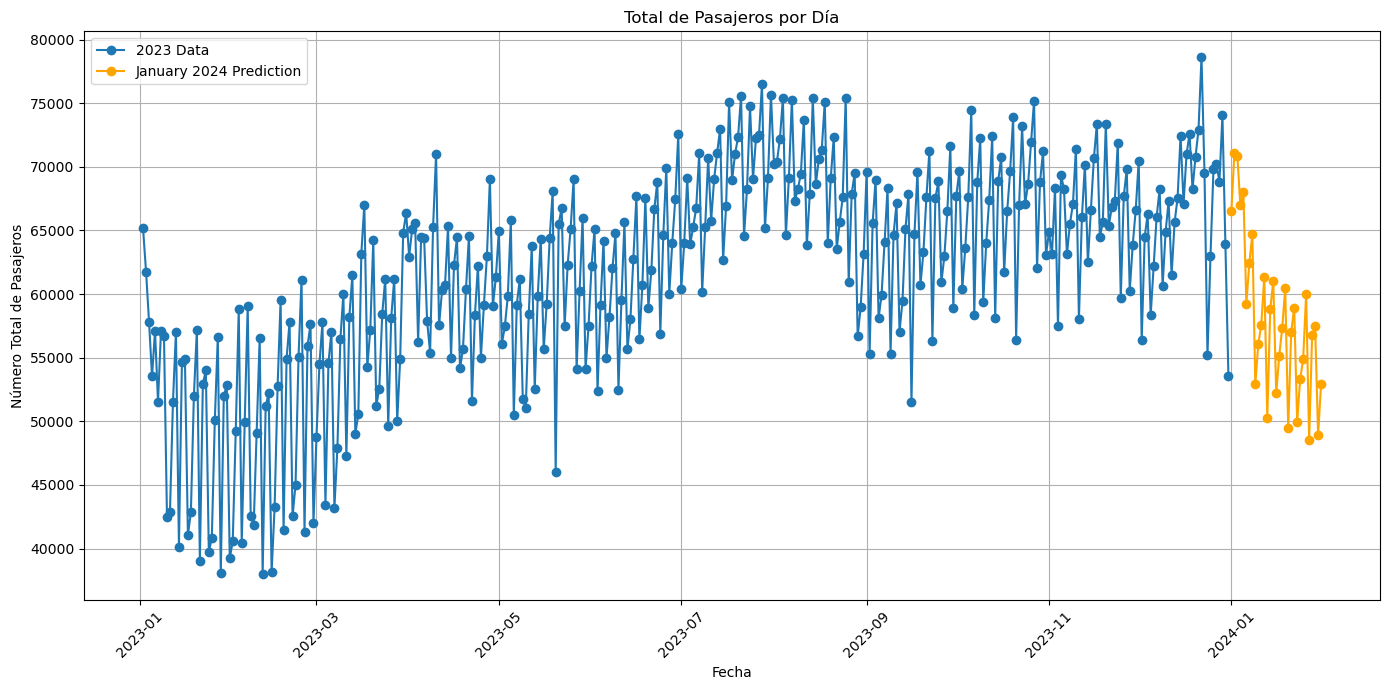

In [43]:


df_flights2023['STD'] = pd.to_datetime(df_flights2023['STD'])
future_month['STD'] = pd.to_datetime(future_month['STD'])


combined_data = pd.concat([df_flights2023, future_month])


daily_passengers = combined_data.groupby(combined_data['STD'].dt.date).agg({'Passengers': 'sum'}).reset_index()
daily_passengers['STD'] = pd.to_datetime(daily_passengers['STD'])  # Asegurar que la columna 'STD' es tipo datetime


data_2023 = daily_passengers[daily_passengers['STD'].dt.year == 2023]
data_2024 = daily_passengers[(daily_passengers['STD'].dt.year == 2024) & (daily_passengers['STD'].dt.month == 1)]


plt.figure(figsize=(14, 7))
plt.plot(data_2023['STD'], data_2023['Passengers'], marker='o', linestyle='-', label='2023 Data')
plt.plot(data_2024['STD'], data_2024['Passengers'], marker='o', linestyle='-', color='orange', label='January 2024 Prediction')
plt.title('Total de Pasajeros por Día')
plt.xlabel('Fecha')
plt.ylabel('Número Total de Pasajeros')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()  
plt.show()


In [37]:
future_month.head()

,Flight_ID,Aeronave,DepartureStation,ArrivalStation,Destination_Type,Origin_Type,STD,STA,Capacity,Passengers,...,STD_Day,STD_Hour,STA_Year,STA_Month,STA_Day,STA_Hour,high_season,Is_Weekend,Passengers,Predicted_Passengers
19,bb319ee8f62b5ae38e6f6da4dbff03cb,XA-VAV,BA,AB,Playa,Ciudad Principal,2024-01-12 08:20:00,2024-01-12 09:20:00,186,155.457287,...,12,8.0,2024,1,12,9.0,0,0,155.457287,155.457287
57,31659639d39b84bc59149bcc3f6d4e7a,XA-VAI,AT,BS,Playa,Ciudad Principal,2024-01-11 06:50:00,2024-01-11 07:55:00,180,156.416235,...,11,7.0,2024,1,11,8.0,0,0,156.416235,156.416235
62,17718d43f541b4e944c5d8bd5b44e6a6,XA-VXO,AW,AX,MX Amigos y Familia,Ciudad Principal,2024-01-25 11:05:00,2024-01-25 11:55:00,240,172.875713,...,25,11.0,2024,1,25,12.0,0,0,172.875713,172.875713
75,43cfcc874d1f88dd5562d8b4657d1559,XA-VIT,AO,AR,Playa,Ciudad Principal,2024-01-12 12:10:00,2024-01-12 12:50:00,186,183.234474,...,12,12.0,2024,1,12,13.0,0,0,183.234474,183.234474
79,10099a86c19b730babcfcc371c6bd98c,XA-VYD,AT,BS,Playa,Ciudad Principal,2024-01-06 14:55:00,2024-01-06 16:00:00,180,137.583842,...,6,15.0,2024,1,6,16.0,0,1,137.583842,137.583842
